In [2]:
import os, sys
from pathlib import Path
import torch
import tifffile as tiff

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 50
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [3]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
pca = test['pca']

img_names = test['img_names']

In [4]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [5]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [6]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [7]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [8]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

In [9]:
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB
from monai.transforms import Compose, ToTensor
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-08-07 23:25:29.152703: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 23:25:29.154114: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 23:25:29.179541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow w

In [10]:
nob_gt=[]
farb_gt=[]

for i in range(251):
    nob_gt = tiff.imread('no_bias/test/'+img_names[i])
    nob_gt = transforms(nob_gt)
    
    farb_gt = tiff.imread('far_bias/test/'+img_names[i])
    farb_gt = transforms(farb_gt)
    

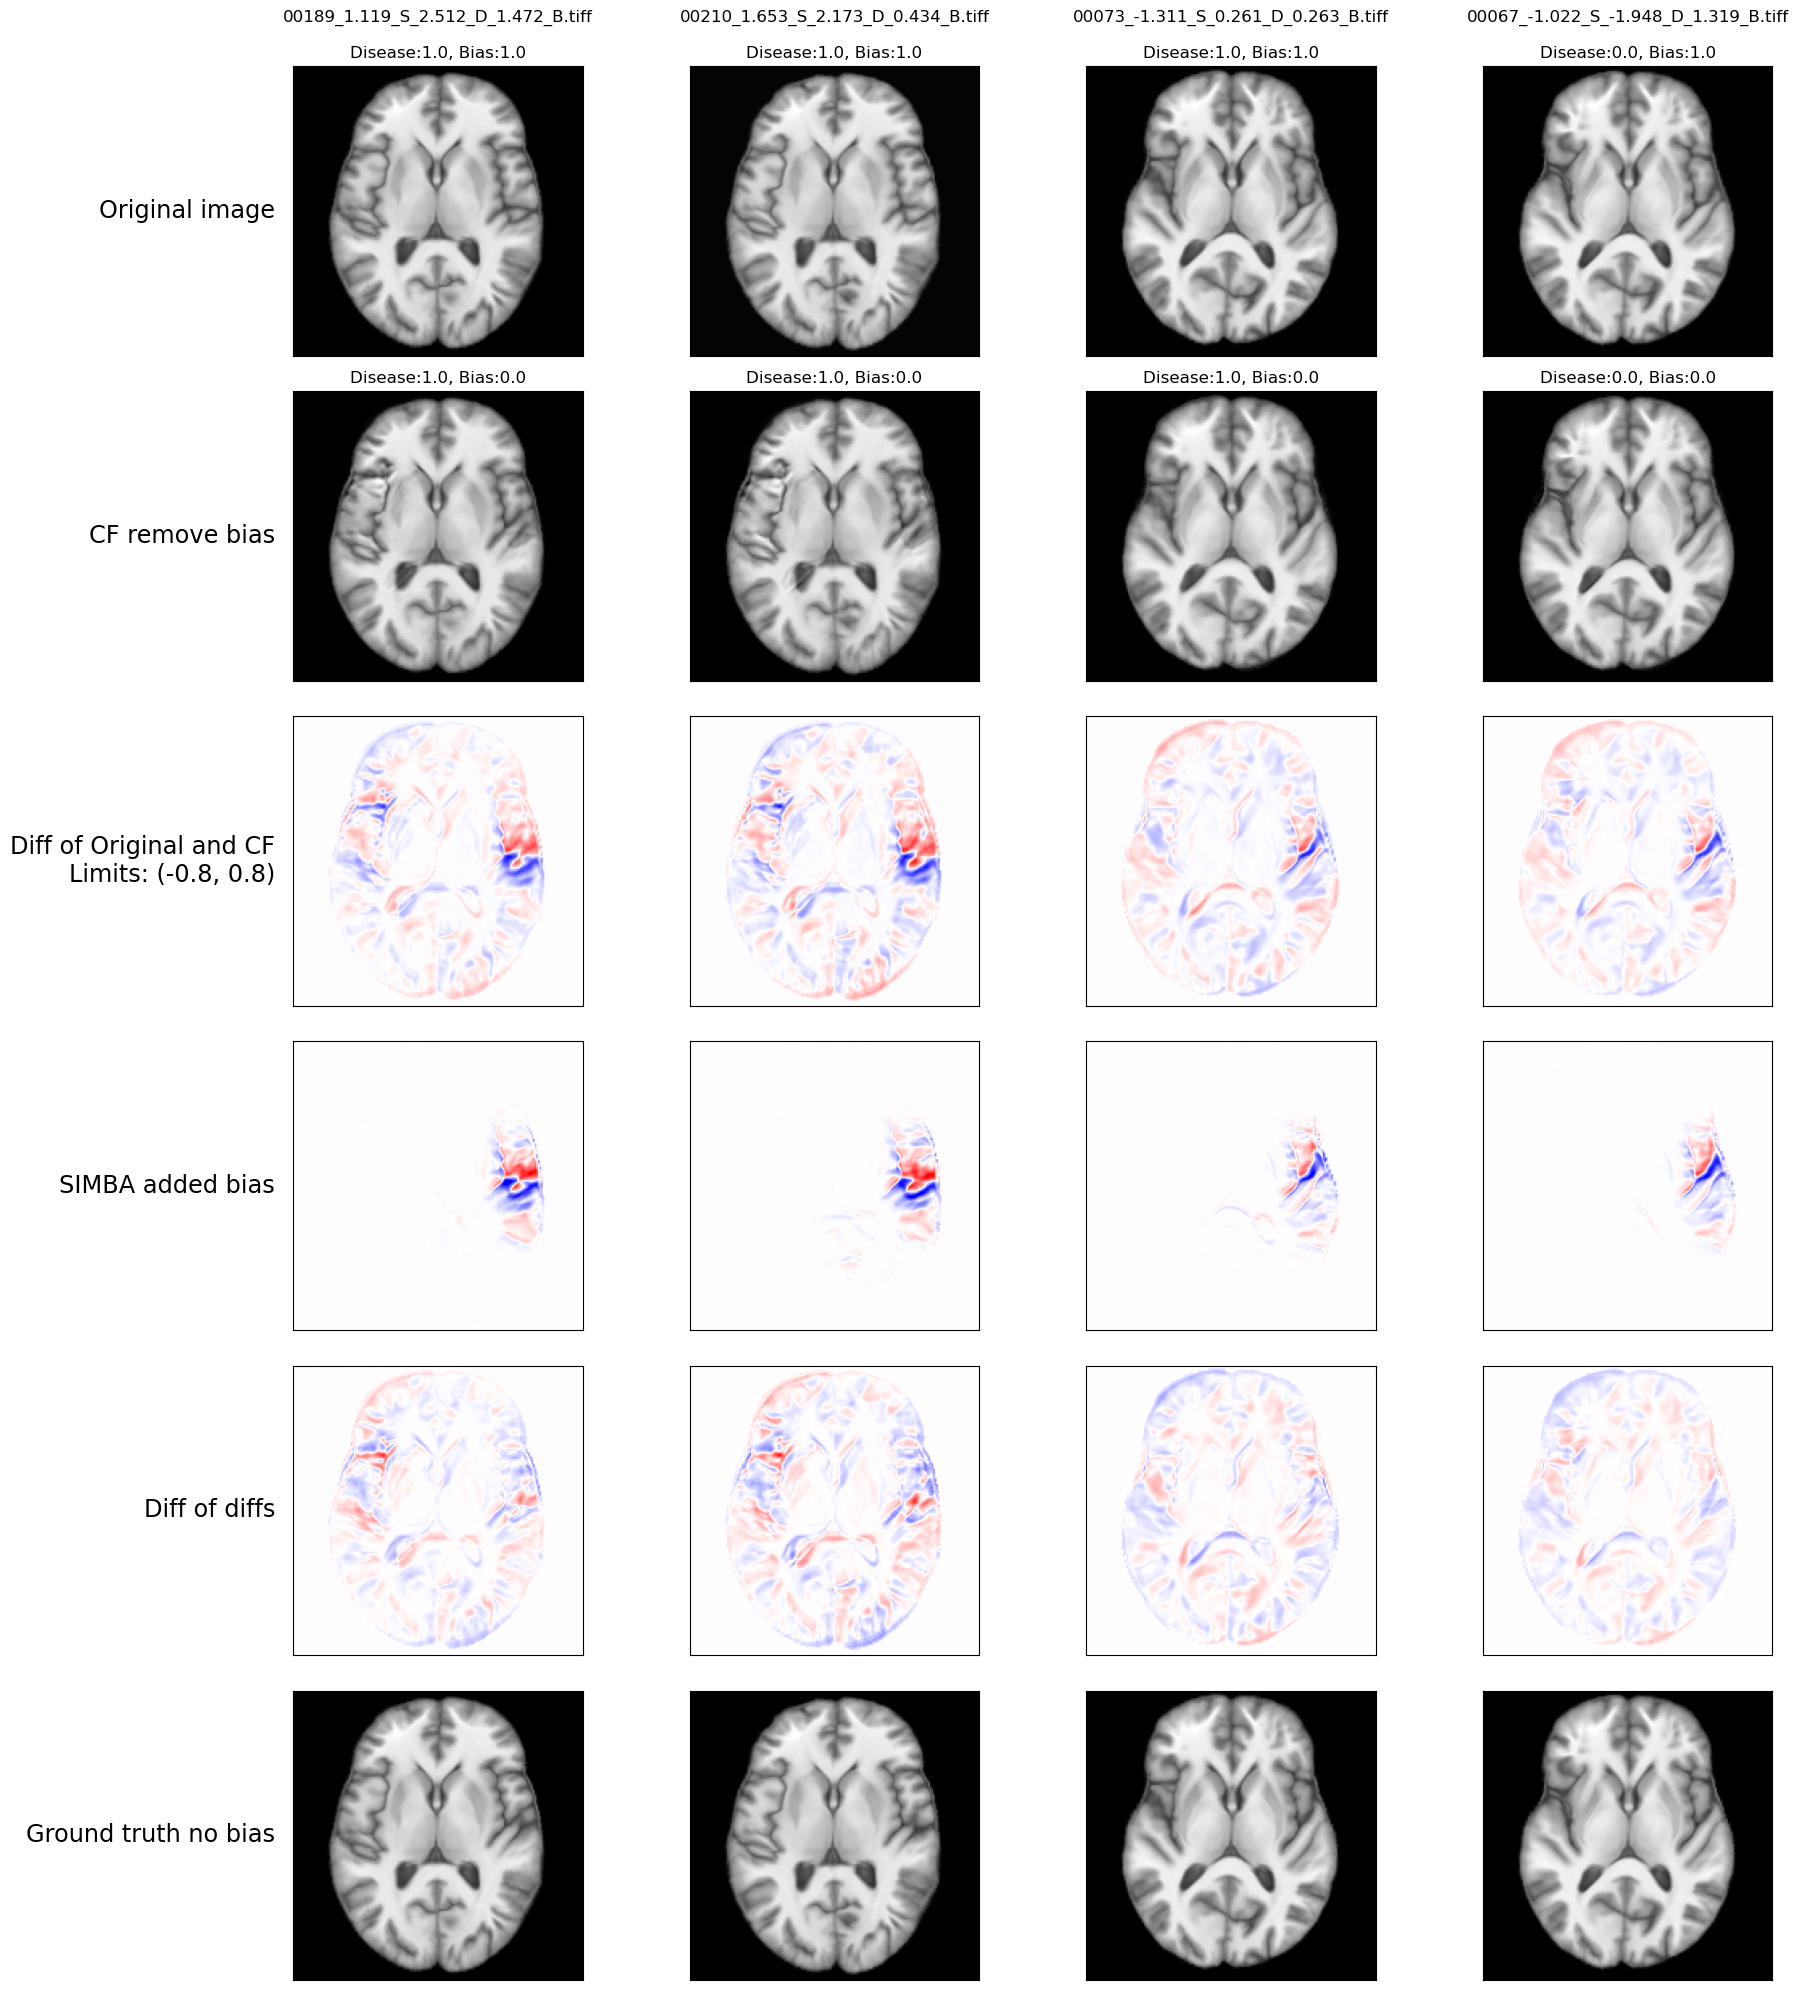

<Figure size 640x480 with 0 Axes>

In [11]:
import SimpleITK as sitk
import numpy as np
import torch

save_name = f'data/{exp_name}/cntr/'
cf_vals = {1:0}
nsamples = 4
image_shape = (180, 180)  # Assuming each image is 180x180

rands = np.random.randint(0, encoded_data.shape[0], nsamples)
d_obs = test_imgs[rands, :]
encoded_obs = encoded_data[rands, :]

t = pca.transform(d_obs)
d_obs = pca.inverse_transform(t)

names = img_names[rands]
dis_obs = disease[rands]
bias_obs = bias[rands]
residuals = d_obs - pca.inverse_transform(encoded_obs)

cf = np.zeros((nsamples, ncomps))
for ev in range(0, ncomps - nbasecomps, nevecs - nbasecomps):
    ed = encoded_obs[:, ev:ev + nevecs]
    X_obs = np.hstack([dis_obs[:, np.newaxis], bias_obs[:, np.newaxis], ed])
    try:
        macaw = torch.load(model_base_path / f'{ev}.pt')
        cc = macaw.counterfactual(X_obs, cf_vals)
    except Exception as e:
        print(e, "Using original")
        cc[:, ncauses:] = X_obs[:, ncauses:].copy()

    cf[:, ev:ev + nevecs] = cc[:, ncauses:]

re_cf = recons(cc[:, 0], cc[:, 1], cf)
re_cf_resd = re_cf[2] + residuals

# Convert numpy arrays to SimpleITK images
def numpy_to_sitk(img):
    return sitk.GetImageFromArray(img.astype(np.float32))

def sitk_to_numpy(img):
    return sitk.GetArrayFromImage(img)

# Perform histogram matching
matched_images = []
for i in range(nsamples):
    # Reshape the arrays to 2D images
    source_img_2d = re_cf_resd[i].reshape(image_shape).astype(np.float32)
    reference_img_2d = d_obs[i].reshape(image_shape).astype(np.float32)

    source_img = numpy_to_sitk(source_img_2d)
    reference_img = numpy_to_sitk(reference_img_2d)

    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(500)
    matcher.SetNumberOfMatchPoints(50)
    matcher.SetThresholdAtMeanIntensity(False)
    matched_img = matcher.Execute(source_img, reference_img)

    # Convert the matched image back to a numpy array and reshape to original shape
    matched_img_array = sitk_to_numpy(matched_img).reshape(-1)
    matched_images.append(matched_img_array)

# Convert the matched images back to a numpy array
re_cf_resd = np.array(matched_images)

# Ensuring values are still in the range [0, 1] after histogram matching
re_cf_resd = np.clip(re_cf_resd, 0, 1)

diff = d_obs - re_cf_resd
fig,axs = plt.subplots(6,nsamples, figsize=(20,20))

lim=.8
lims=(-lim,lim)

for i in range(nsamples):
    axs[0,i].imshow(d_obs[i].reshape(crop_size,crop_size),cmap='gray')
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'{names[i]}\n\nDisease:{X_obs[i,0]}, Bias:{X_obs[i,1]}')

    axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
    axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{cc[i,0]}, Bias:{cc[i,1]}')

    axs[2,i].imshow(diff[i].reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    img = tiff.imread('no_bias/test/'+img_names[rands[i]])
    img = transforms(img)
    
    t = pca.transform(img.reshape(1,-1))
    X_recon = pca.inverse_transform(t)
    
    # shows the bias Emma added
    axs[3,i].imshow(d_obs[i].reshape(crop_size,crop_size) - X_recon.reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[3,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    # diff between cf no_bias and ground truth no_bias, ideally would have no difference
    axs[4,i].imshow((re_cf_resd[i].reshape(crop_size,crop_size)) - X_recon.reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[4,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    axs[5,i].imshow(X_recon.reshape(crop_size,crop_size),cmap='gray')
    axs[5,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Add labels to the left side of each row
for ax, label in zip(axs[:, 0], ['Original image', 'CF remove bias', f'Diff of Original and CF\nLimits: {lims}', 'SIMBA added bias', 'Diff of diffs', 'Ground truth no bias']):
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='xx-large', ha='right', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.15)  # Adjust to make room for the labels
plt.show()

if not os.path.exists(save_name):
    os.makedirs(save_name)

plt.savefig(save_name+f"cf1.pdf")

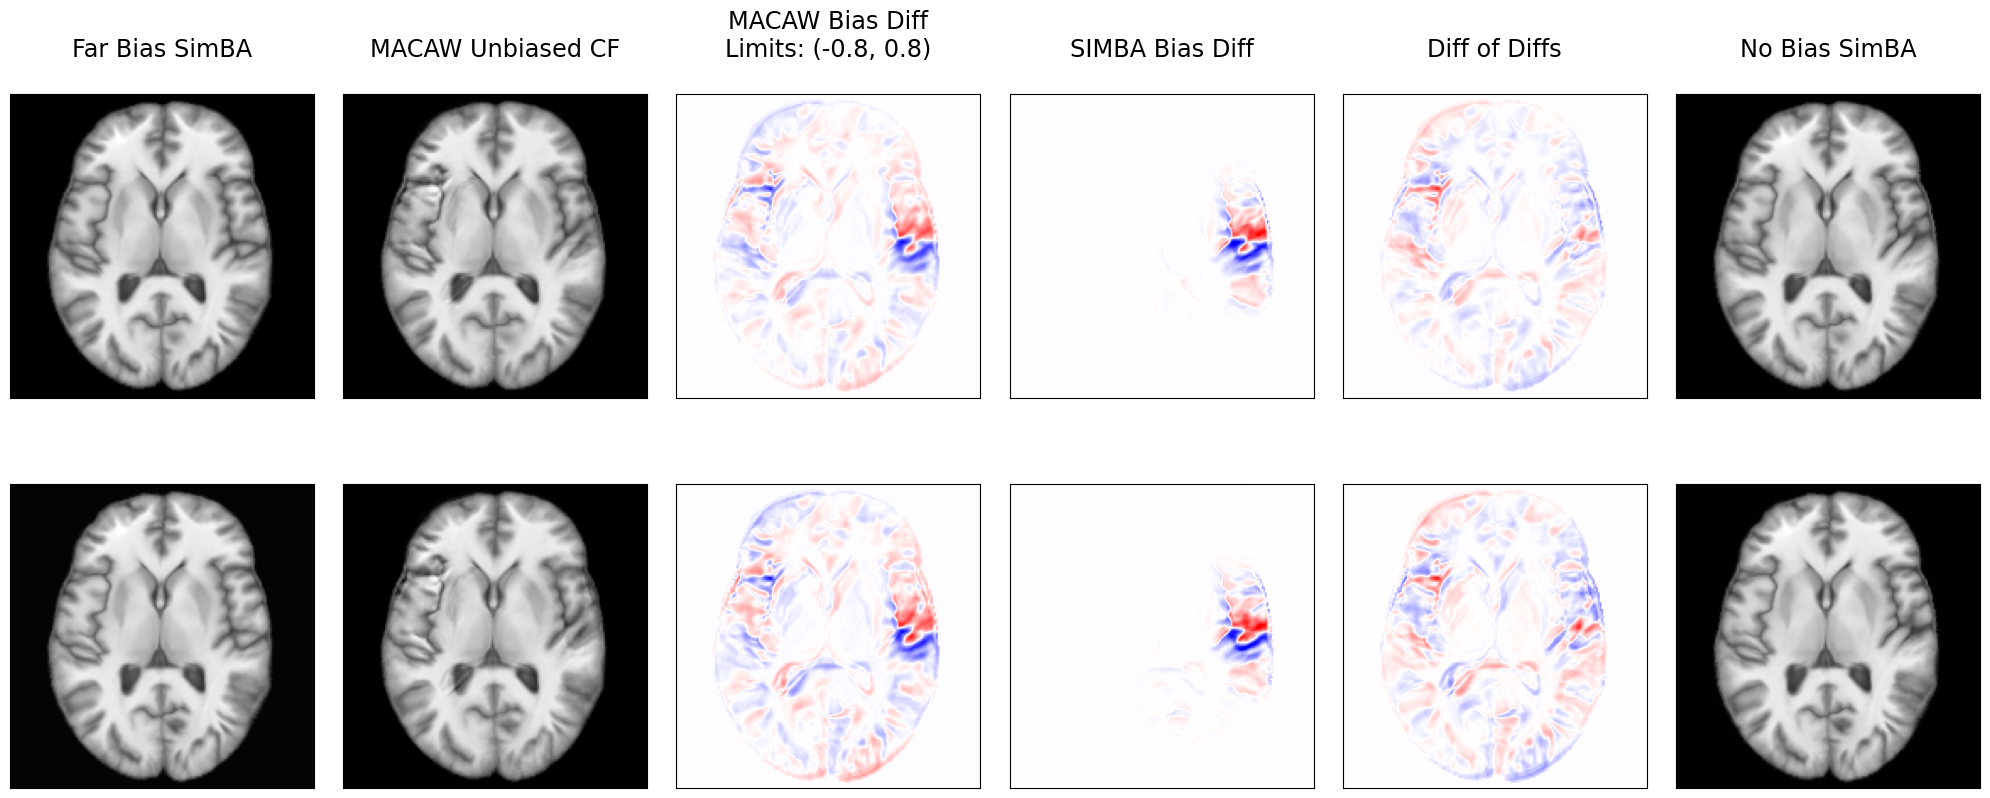

In [12]:
import matplotlib.pyplot as plt
import tifffile as tiff

# Assuming variables are defined: nsamples, d_obs, crop_size, names, X_obs, make_img, re_cf_resd, diff, img_names, rands, transforms, pca, cc

# Set nsamples to 2 for the updated requirement
nsamples = 2

fig, axs = plt.subplots(nsamples, 6, figsize=(20, 10))

lim = 0.8
lims = (-lim, lim)

for i in range(nsamples):
    # Original Image
    axs[i, 0].imshow(d_obs[i].reshape(crop_size, crop_size), cmap='gray')
    axs[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    # axs[i, 0].set_title(f'{names[i]}\nDisease: {X_obs[i, 0]}, Bias: {X_obs[i, 1]}')

    # CF remove bias
    axs[i, 1].imshow(make_img(re_cf_resd[i]), cmap='gray')
    axs[i, 1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    # axs[i, 1].set_title(f'Disease: {cc[i, 0]}, Bias: {cc[i, 1]}')

    # Difference Image
    axs[i, 2].imshow(diff[i].reshape(crop_size, crop_size), cmap='seismic', clim=lims)
    axs[i, 2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # SIMBA added bias
    img = tiff.imread('no_bias/test/' + img_names[rands[i]])
    img = transforms(img)
    t = pca.transform(img.reshape(1, -1))
    X_recon = pca.inverse_transform(t)
    axs[i, 3].imshow(d_obs[i].reshape(crop_size, crop_size) - X_recon.reshape(crop_size, crop_size), cmap='seismic', clim=lims)
    axs[i, 3].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # Difference between CF no_bias and ground truth no_bias
    axs[i, 4].imshow((re_cf_resd[i].reshape(crop_size, crop_size)) - X_recon.reshape(crop_size, crop_size), cmap='seismic', clim=lims)
    axs[i, 4].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # Ground truth no bias
    axs[i, 5].imshow(X_recon.reshape(crop_size, crop_size), cmap='gray')
    axs[i, 5].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Add labels to the top of each column
column_labels = ['Far Bias SimBA', 'MACAW Unbiased CF', f'MACAW Bias Diff\nLimits: {lims}', 'SIMBA Bias Diff', 'Diff of Diffs', 'No Bias SimBA']
for ax, label in zip(axs[0], column_labels):
    ax.annotate(label, xy=(0.5, 1.1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust to make room for the labels
plt.show()


In [13]:
img_names[rands[i]]

'00210_1.653_S_2.173_D_0.434_B.tiff'

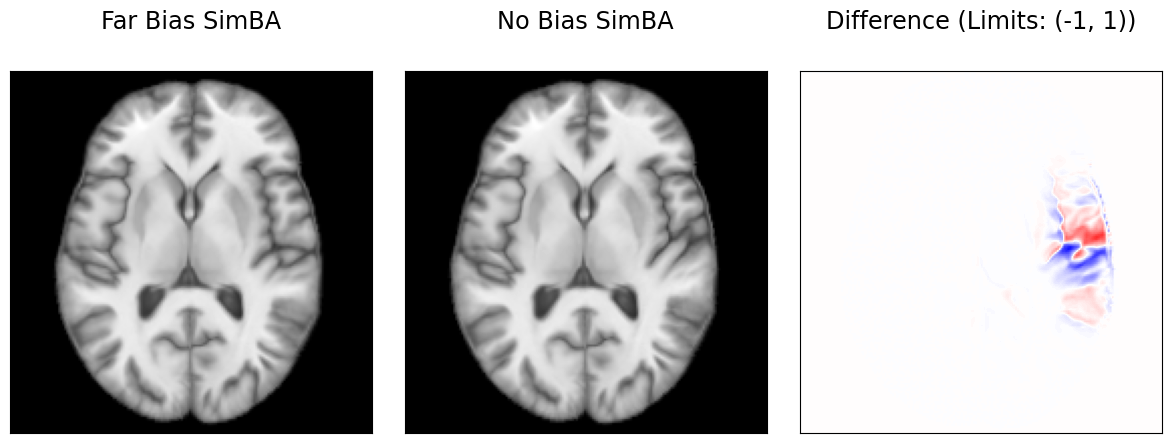

In [14]:
import matplotlib.pyplot as plt
import tifffile as tiff

# Assuming variables are defined: d_obs, crop_size, names, X_obs, make_img, re_cf_resd, diff, img_names, rands, transforms, pca, cc

# Set to display only one sample
nsamples = 1

lim = 1
lims = (-lim, lim)

# First Figure
fig1, axs1 = plt.subplots(nsamples, 3, figsize=(12, 5))

i = 0  # Only one sample

# Original Image
axs1[0].imshow(d_obs[i].reshape(crop_size, crop_size), cmap='gray')
axs1[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Ground truth no bias
img = tiff.imread('no_bias/test/' + img_names[rands[i]])
img = transforms(img)
t = pca.transform(img.reshape(1, -1))
X_recon = pca.inverse_transform(t)
axs1[1].imshow(X_recon.reshape(crop_size, crop_size), cmap='gray')
axs1[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Difference between Original and Ground truth no bias
axs1[2].imshow(d_obs[i].reshape(crop_size, crop_size) - X_recon.reshape(crop_size, crop_size), cmap='seismic', clim=lims)
axs1[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Add labels to the top of each column
column_labels1 = ['Far Bias SimBA', 'No Bias SimBA', f'Difference (Limits: {lims})']
for ax, label in zip(axs1, column_labels1):
    ax.annotate(label, xy=(0.5, 1.1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Adjust to make room for the labels
plt.show()


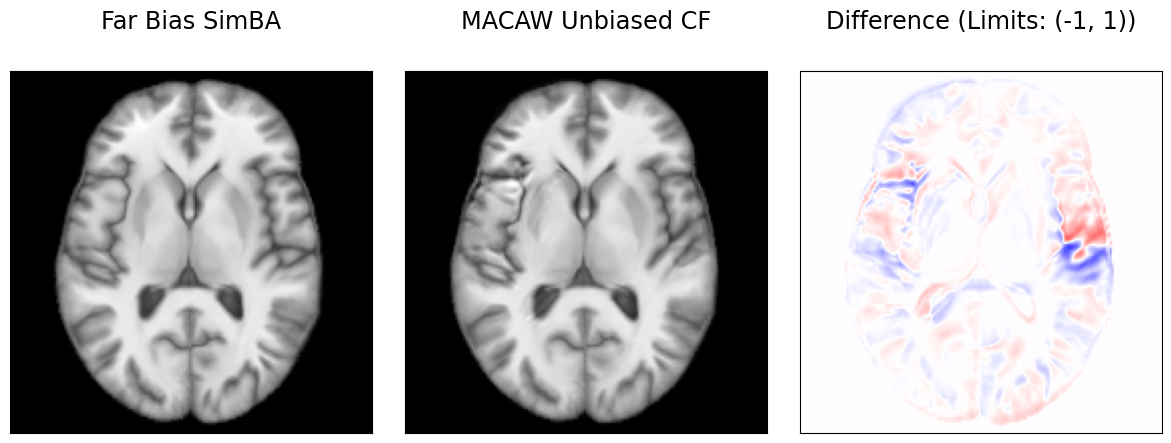

In [15]:
# Second Figure
fig2, axs2 = plt.subplots(nsamples, 3, figsize=(12, 5))

i = 0  # Only one sample

# Original Image
axs2[0].imshow(d_obs[i].reshape(crop_size, crop_size), cmap='gray')
axs2[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# CF remove bias
axs2[1].imshow(make_img(re_cf_resd[i]), cmap='gray')
axs2[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Difference between Original and CF remove bias
axs2[2].imshow(diff[i].reshape(crop_size, crop_size), cmap='seismic', clim=lims)
axs2[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Add labels to the top of each column
column_labels2 = ['Far Bias SimBA', 'MACAW Unbiased CF', f'Difference (Limits: {lims})']
for ax, label in zip(axs2, column_labels2):
    ax.annotate(label, xy=(0.5, 1.1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Adjust to make room for the labels
plt.show()


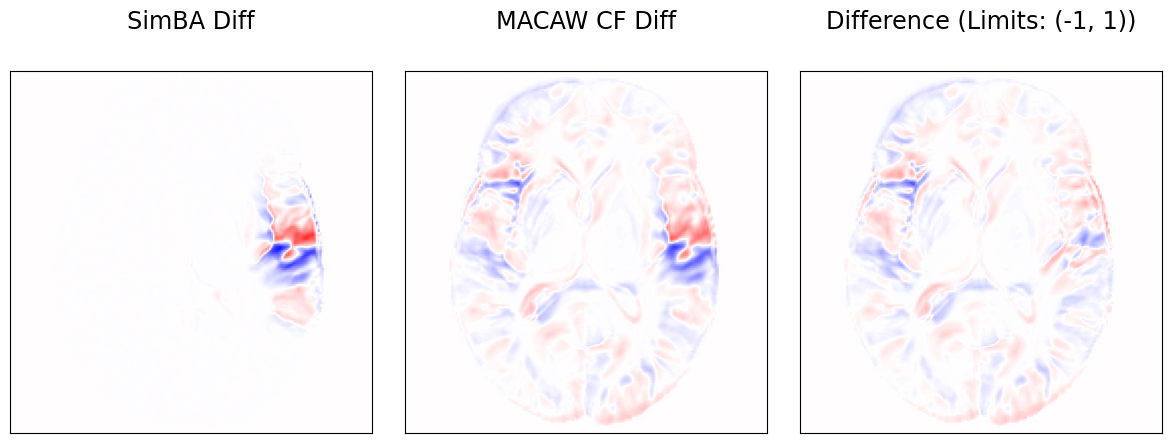

In [16]:
# Third Figure
fig3, axs3 = plt.subplots(nsamples, 3, figsize=(12, 5))

i = 0  # Only one sample

# Difference between Original and Ground truth no bias
img = tiff.imread('no_bias/test/' + img_names[rands[i]])
img = transforms(img)
t = pca.transform(img.reshape(1, -1))
X_recon = pca.inverse_transform(t)

diff_gt = d_obs[i].reshape(crop_size, crop_size) - X_recon.reshape(crop_size, crop_size)
axs3[0].imshow(diff_gt, cmap='seismic', clim=lims)
axs3[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Difference between Original and CF remove bias
axs3[1].imshow(diff[i].reshape(crop_size, crop_size), cmap='seismic', clim=lims)
axs3[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Difference between the two differences
axs3[2].imshow(diff[i].reshape(crop_size, crop_size) - diff_gt, cmap='seismic', clim=lims)
axs3[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Add labels to the top of each column
column_labels3 = ['SimBA Diff', 'MACAW CF Diff', f'Difference (Limits: {lims})']
for ax, label in zip(axs3, column_labels3):
    ax.annotate(label, xy=(0.5, 1.1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Adjust to make room for the labels
plt.show()


In [17]:
for i in range(nsamples):
    print(min(re_cf_resd[i]),max(re_cf_resd[i]))

0.0 0.9988565


In [18]:
i=0

(array([1.4059e+04, 1.3900e+02, 1.1000e+02, 1.1600e+02, 1.7200e+02,
        2.9200e+02, 4.2800e+02, 6.3200e+02, 8.1700e+02, 1.0010e+03,
        1.1900e+03, 1.4280e+03, 1.5870e+03, 1.6060e+03, 1.5650e+03,
        1.5980e+03, 1.8970e+03, 2.1250e+03, 1.6260e+03, 1.2000e+01]),
 array([0.        , 0.04994282, 0.09988565, 0.14982848, 0.1997713 ,
        0.24971412, 0.29965696, 0.34959978, 0.3995426 , 0.44948542,
        0.49942824, 0.54937106, 0.59931391, 0.64925671, 0.69919956,
        0.74914235, 0.7990852 , 0.84902799, 0.89897084, 0.94891363,
        0.99885648]),
 <BarContainer object of 20 artists>)

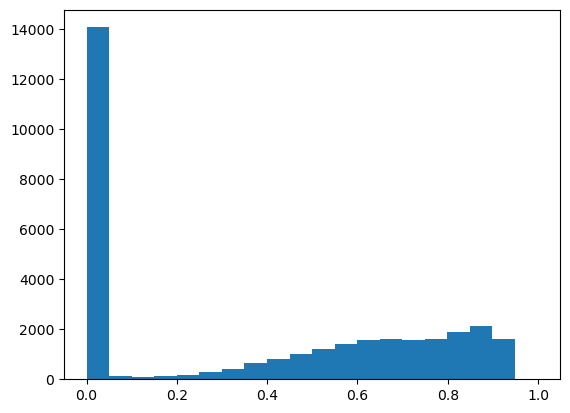

In [19]:
plt.hist(re_cf_resd[i], bins=20)
# plt.yscale("log")

(array([14033.,   151.,   136.,   106.,   172.,   283.,   419.,   631.,
          810.,   997.,  1212.,  1415.,  1594.,  1616.,  1533.,  1616.,
         1908.,  2111.,  1565.,    92.]),
 array([-0.00169077,  0.04833659,  0.09836396,  0.14839132,  0.19841868,
         0.24844605,  0.29847342,  0.34850076,  0.39852813,  0.4485555 ,
         0.49858287,  0.54861021,  0.59863758,  0.64866495,  0.69869232,
         0.74871969,  0.79874706,  0.84877437,  0.89880174,  0.94882911,
         0.99885648]),
 <BarContainer object of 20 artists>)

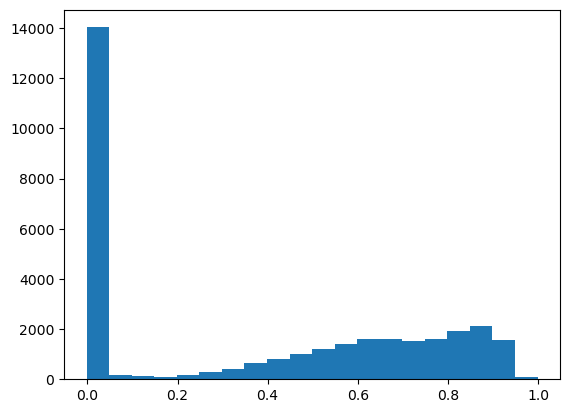

In [20]:
plt.hist(d_obs[i], bins=20)
# plt.yscale("log")

In [21]:
n = rands[2]

In [22]:
fb_img = tiff.imread('far_bias/test/'+ img_names[n])
fb_img = transforms(fb_img).reshape(crop_size,crop_size)

nb_img = tiff.imread('no_bias/test/'+ img_names[n])
nb_img = transforms(nb_img).reshape(crop_size,crop_size)

In [23]:
img_names[n]

'00073_-1.311_S_0.261_D_0.263_B.tiff'

In [24]:
print(disease[n], bias[n])

1 1


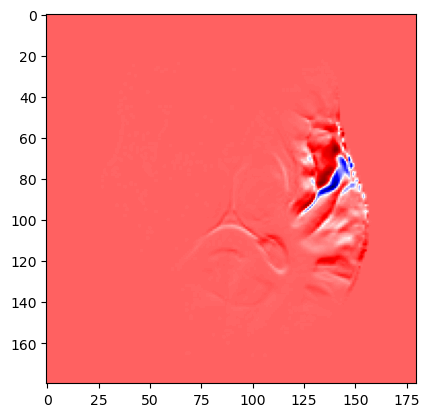

In [25]:
plt.imshow(fb_img-nb_img,cmap='seismic')

In [26]:
re_cf_resd[2]

array([0.00089538, 0.00089478, 0.00088174, ..., 0.00088431, 0.00088431,
       0.00088431], dtype=float32)